In [132]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Original Image')

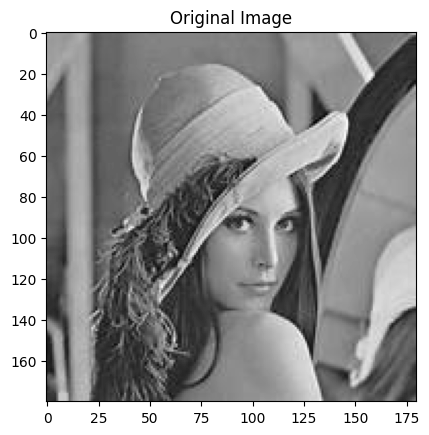

In [133]:
image = cv2.imread('lena.jpg',0)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

In [64]:
def apply_gaussian_blur(image, kernel_size):
    def gaussian_kernel(size, sigma):
        kernel = np.fromfunction(
            lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * 
                          np.exp(- ((x - (size-1)/2) ** 2 + (y - (size-1)/2) ** 2) / (2 * sigma ** 2)),
            (size, size)
        )
        return kernel / np.sum(kernel)

   
    if kernel_size % 2 == 0:
        kernel_size += 1

   
    kernel = gaussian_kernel(kernel_size, sigma=1.0)

 
    rows, cols = image.shape

 
    k_half = kernel_size // 2

  
    output = np.zeros_like(image) 

    for i in range(k_half, rows - k_half):
        for j in range(k_half, cols - k_half):
            output[i, j] = np.sum(image[i - k_half: i + k_half + 1, j - k_half: j + k_half + 1] * kernel)

    return output[k_half:rows-k_half, k_half:cols-k_half]

In [65]:
def compute_gradient_magnitude_and_orientation(image, sobel_kernel_size):

    if sobel_kernel_size == 3:
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    elif sobel_kernel_size == 5:
        sobel_x = np.array([[-1, -2, 0, 2, 1], [-2, -3, 0, 3, 2], [-3, -5, 0, 5, 3], [-2, -3, 0, 3, 2], [-1, -2, 0, 2, 1]])
        sobel_y = np.array([[-1, -2, -3, -2, -1], [-2, -3, -5, -3, -2], [0, 0, 0, 0, 0], [2, 3, 5, 3, 2], [1, 2, 3, 2, 1]])
    else:
        sys.exit("Sobel kernel size should be 3 or 5!")

    rows, cols = image.shape

    gradient_x = np.zeros_like(image, dtype=np.float64)
    gradient_y = np.zeros_like(image, dtype=np.float64)

    half_size = sobel_kernel_size // 2
    for i in range(half_size, rows - half_size):
        for j in range(half_size, cols - half_size):
            window = image[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]
            gradient_x[i, j] = np.sum(window * sobel_x)
            gradient_y[i, j] = np.sum(window * sobel_y)

    magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    
    orientation = np.arctan2(gradient_y, gradient_x)

    return magnitude, orientation

In [66]:
def apply_non_max_suppression(magnitude, orientation):
    suppressed_magnitude = np.copy(magnitude)
    rows, cols = magnitude.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = orientation[i][j]
            q = [0, 0]
            if (-np.pi/8 <= angle < np.pi/8) or (7*np.pi/8 <= angle):
                q[0] = magnitude[i][j+1]
                q[1] = magnitude[i][j-1]
            elif (np.pi/8 <= angle < 3*np.pi/8):
                q[0] = magnitude[i+1][j+1]
                q[1] = magnitude[i-1][j-1]
            elif (3*np.pi/8 <= angle < 5*np.pi/8):
                q[0] = magnitude[i+1][j]
                q[1] = magnitude[i-1][j]
            else:
                q[0] = magnitude[i-1][j+1]
                q[1] = magnitude[i+1][j-1]
            
            if magnitude[i][j] < max(q[0], q[1]):
                suppressed_magnitude[i][j] = 0
    
    return suppressed_magnitude

In [134]:
def apply_edge_tracking_by_hysteresis(magnitude, low_threshold, high_threshold):
    rows, cols = magnitude.shape
    edge_map = np.zeros((rows, cols), dtype=np.uint8)
    
    strong_edge_i, strong_edge_j = np.where(magnitude >= high_threshold)
    weak_edge_i, weak_edge_j = np.where((magnitude >= low_threshold) & (magnitude < high_threshold))
    
    edge_map[strong_edge_i, strong_edge_j] = 255

    for i, j in zip(weak_edge_i, weak_edge_j):
        if (edge_map[i-1:i+2, j-1:j+2] == 255).any():
            edge_map[i, j] = 255
    
    return edge_map

Text(0.5, 1.0, 'Canny Image')

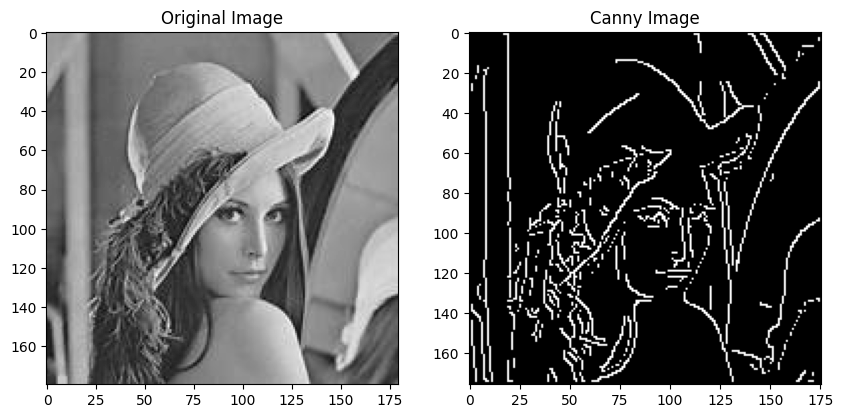

In [135]:
smoothed_image = apply_gaussian_blur(image, 5)

magnitude, orientation = compute_gradient_magnitude_and_orientation(smoothed_image, 3)

mx = apply_non_max_suppression(magnitude, orientation)

low_threshold, high_threshold = 70, 100
emap = apply_edge_tracking_by_hysteresis(mx, low_threshold, high_threshold)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(emap, cmap='gray')
plt.title("Canny Image")

Text(0.5, 1.0, 'Canny Image')

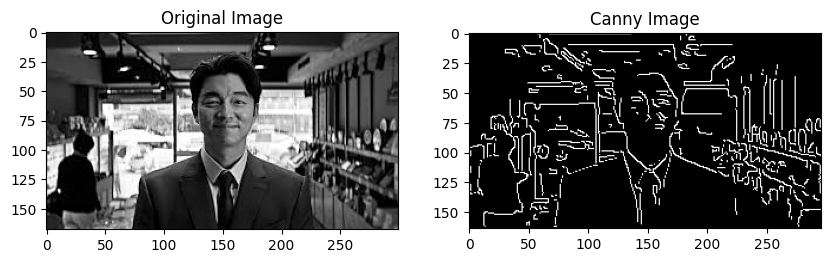

In [136]:
image = cv2.imread("download.jpeg", 0)
smoothed_image = apply_gaussian_blur(image, 5)

magnitude, orientation = compute_gradient_magnitude_and_orientation(smoothed_image, 3)

mx = apply_non_max_suppression(magnitude, orientation)

low_threshold, high_threshold = 125, 200
emap = apply_edge_tracking_by_hysteresis(mx, low_threshold, high_threshold)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(emap, cmap='gray')
plt.title("Canny Image")

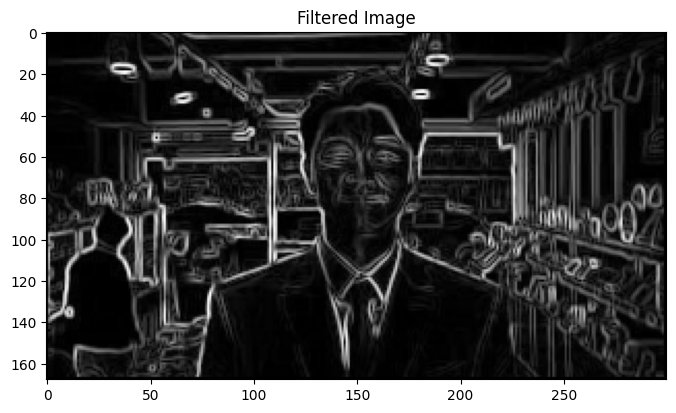

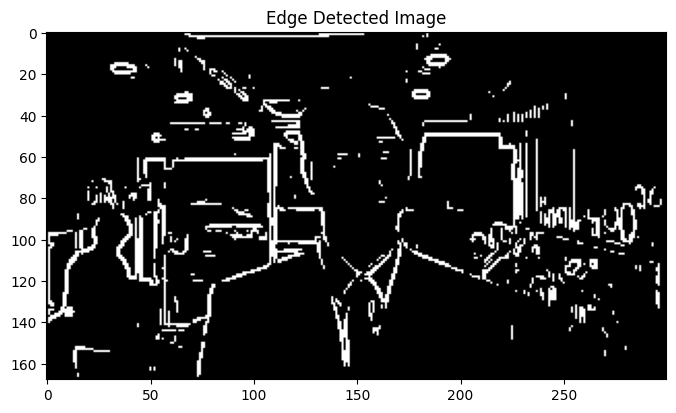

In [137]:

def apply_prewitt_edge_detection(input_image):
   
    input_image = input_image.astype(np.float64)
    
    
    filtered_image = np.zeros(input_image.shape)
    
    Mx = np.array([-1, 0, 1, -1, 0, 1, -1, 0, 1]).reshape(3, 3)
    My = np.array([-1, -1, -1, 0, 0, 0, 1, 1, 1]).reshape(3, 3)
    
    for i in range(1, input_image.shape[0] - 1):
        for j in range(1, input_image.shape[1] - 1):
           
            Gx = np.sum(Mx * input_image[i-1:i+2, j-1:j+2])
            Gy = np.sum(My * input_image[i-1:i+2, j-1:j+2])
            
            filtered_image[i, j] = np.sqrt(Gx**2 + Gy**2)
    
    filtered_image = (filtered_image / filtered_image.max() * 255).astype(np.uint8)
    plt.figure(figsize=(8, 6))
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.show()
    
    threshold_value = 100  # varies between [0 255]
    output_image = np.maximum(filtered_image, threshold_value)
    output_image[output_image == threshold_value] = 0
    output_image = (output_image > 0).astype(np.uint8) * 255
    
    plt.figure(figsize=(8, 6))
    plt.imshow(output_image, cmap='gray')
    plt.title('Edge Detected Image')
    plt.show()
    
input_image = np.array(Image.open('download.jpeg').convert('L'))

apply_prewitt_edge_detection(input_image)


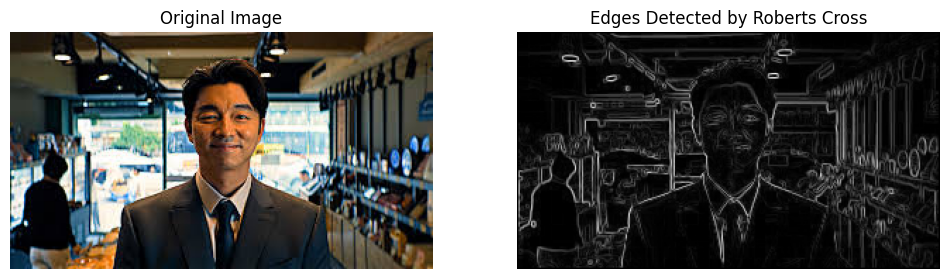

In [139]:
def roberts_cross_edge_detection(input_image):
    if len(input_image.shape) == 3:
        input_image = np.mean(input_image, axis=2).astype(np.uint8)
    
    kernel_x = np.array([[1, 0], [0, -1]])
    kernel_y = np.array([[0, 1], [-1, 0]])
    
    output_image = np.zeros(input_image.shape)
    
    for i in range(1, input_image.shape[0] - 1):
        for j in range(1, input_image.shape[1] - 1):
            patch = input_image[i-1:i+1, j-1:j+1]
            Gx = np.sum(patch * kernel_x)
            Gy = np.sum(patch * kernel_y)
            output_image[i, j] = np.sqrt(Gx**2 + Gy**2)
    
    output_image = (output_image / output_image.max() * 255).astype(np.uint8)
    
    return output_image

input_image = np.array(Image.open('download.jpeg'))
output_image = roberts_cross_edge_detection(input_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Edges Detected by Roberts Cross')
plt.axis('off')

plt.show()